In [1]:
"""
模型評估腳本 - 分析每個模型的分類能力
包含 Best 3 / Worst 3 類別分析
"""
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 設定
IMG_FOLDER = '/mnt/f/course/computer_vision/final_proj_img/final_proj_img/pic/'
TXT_FOLDER = '/mnt/f/course/computer_vision/txt/'
MODEL_DIR = '/mnt/f/course/computer_vision/models/'
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


2026-01-08 23:10:35.466762: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-08 23:10:35.625666: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767885035.689072    1438 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767885035.707014    1438 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-08 23:10:35.850344: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
"""
載入資料集
"""
def load_dataset_from_name_txt(img_folder, txt_folder):
    filename_list = []
    class_name_list = []
    
    name_txt_path = os.path.join(txt_folder, 'name.txt')
    print(f"Reading name.txt from: {name_txt_path}")
    
    with open(name_txt_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                filename_list.append(parts[0])
                class_name_list.append(parts[1])
    
    unique_classes = sorted(list(set(class_name_list)))
    class_to_idx = {name: i for i, name in enumerate(unique_classes)}
    print(f"Detected {len(unique_classes)} classes.")

    query_txt_path = os.path.join(txt_folder, 'query.txt')
    with open(query_txt_path, 'r') as f:
        test_indices = set([int(line.strip()) - 1 for line in f])

    train_paths, train_labels = [], []
    test_paths, test_labels = [], []
    missing_count = 0

    for idx, filename in enumerate(filename_list):
        class_name = class_name_list[idx]
        full_path = os.path.join(img_folder, class_name, filename)
        label_idx = class_to_idx[class_name]
        
        if not os.path.exists(full_path):
            missing_count += 1
            continue

        if idx in test_indices:
            test_paths.append(full_path)
            test_labels.append(label_idx)
        else:
            train_paths.append(full_path)
            train_labels.append(label_idx)

    if missing_count > 0:
        print(f"Total missing files: {missing_count}")

    idx_to_class = {i: name for name, i in class_to_idx.items()}
    return (train_paths, train_labels), (test_paths, test_labels), len(unique_classes), idx_to_class

# 載入資料
(tr_x, tr_y), (te_x, te_y), num_classes, idx_to_class = load_dataset_from_name_txt(IMG_FOLDER, TXT_FOLDER)
class_names = [idx_to_class[i] for i in range(num_classes)]

print(f"Training Data: {len(tr_x)} images")
print(f"Testing Data: {len(te_x)} images")
print(f"Classes: {class_names[:5]}... (showing first 5)")


Reading name.txt from: /mnt/f/course/computer_vision/txt/name.txt
Detected 50 classes.
Total missing files: 2
Training Data: 6999 images
Testing Data: 2999 images
Classes: ['AncestorDinoArt', 'Archit', 'BWimage', 'Baseball', 'Basketball']... (showing first 5)


In [3]:
"""
準備測試資料集
"""
# 模型檔案路徑
model_files = {
    'VGG16': 'VGG16_finetuned_0104.keras',
    'VGG19': 'VGG19_finetuned_0104.keras',
    'ResNet50': 'ResNet50_finetuned_0104.keras',
    'ResNet101': 'ResNet101_finetuned_0104.keras',
    'ResNet152': 'ResNet152_finetuned_0104.keras',
}

# 準備測試資料 (不含 one-hot 編碼的標籤，用於 sklearn)
def preprocess_for_eval(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    return img, label

test_ds_eval = tf.data.Dataset.from_tensor_slices((te_x, te_y))
test_ds_eval = test_ds_eval.map(preprocess_for_eval, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_eval = test_ds_eval.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 取得所有真實標籤
y_true = np.array(te_y)

print(f"Total test samples: {len(y_true)}")
print(f"Number of classes: {num_classes}")
print(f"Models to evaluate: {list(model_files.keys())}")
print("="*60)


Total test samples: 2999
Number of classes: 50
Models to evaluate: ['VGG16', 'VGG19', 'ResNet50', 'ResNet101', 'ResNet152']


I0000 00:00:1767885067.447719    1438 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [5]:
"""
載入每個模型並計算每個類別的指標
"""
per_class_results = {}

for model_name, model_file in model_files.items():
    model_path = os.path.join(MODEL_DIR, model_file)
    
    if not os.path.exists(model_path):
        print(f"⚠️ Model not found: {model_path}")
        continue
    
    print(f"\n{'='*60}")
    print(f"Analyzing {model_name}...")
    print(f"{'='*60}")
    
    # 載入模型
    model = tf.keras.models.load_model(model_path)
    
    # 預測
    y_pred_probs = model.predict(test_ds_eval, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # 使用 sklearn 計算每個類別的指標
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)
    
    # 提取每個類別的 F1 score
    class_f1_scores = {}
    class_metrics = {}
    for i, class_name in enumerate(class_names):
        if class_name in report:
            class_f1_scores[class_name] = report[class_name]['f1-score']
            class_metrics[class_name] = {
                'precision': report[class_name]['precision'],
                'recall': report[class_name]['recall'],
                'f1-score': report[class_name]['f1-score'],
                'support': report[class_name]['support']
            }
    
    # 排序找出 Best 3 和 Worst 3
    sorted_classes = sorted(class_f1_scores.items(), key=lambda x: x[1], reverse=True)
    best_3 = sorted_classes[:3]
    worst_3 = sorted_classes[-3:]
    
    per_class_results[model_name] = {
        'class_metrics': class_metrics,
        'best_3': best_3,
        'worst_3': worst_3,
        'y_pred': y_pred,
        'overall_accuracy': report['accuracy'],
        'macro_f1': report['macro avg']['f1-score'],
    }
    
    # 顯示結果
    print(f"\n📊 Overall: Accuracy={report['accuracy']:.4f}, Macro F1={report['macro avg']['f1-score']:.4f}")
    
    print(f"\n✅ Best 3 Classes (by F1-score):")
    for rank, (cls, f1) in enumerate(best_3, 1):
        metrics = class_metrics[cls]
        print(f"   {rank}. {cls}: F1={f1:.4f} (Precision={metrics['precision']:.4f}, Recall={metrics['recall']:.4f}, Support={metrics['support']})")
    
    print(f"\n❌ Worst 3 Classes (by F1-score):")
    for rank, (cls, f1) in enumerate(worst_3, 1):
        metrics = class_metrics[cls]
        print(f"   {rank}. {cls}: F1={f1:.4f} (Precision={metrics['precision']:.4f}, Recall={metrics['recall']:.4f}, Support={metrics['support']})")
    
    # 清理記憶體
    del model
    tf.keras.backend.clear_session()

print("\n" + "="*60)
print("Per-Model Analysis Complete!")
print("="*60)



Analyzing VGG16...
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step

📊 Overall: Accuracy=0.9486, Macro F1=0.9488

✅ Best 3 Classes (by F1-score):
   1. AncestorDinoArt: F1=1.0000 (Precision=1.0000, Recall=1.0000, Support=60.0)
   2. Penguin: F1=1.0000 (Precision=1.0000, Recall=1.0000, Support=60.0)
   3. Satelliteimage: F1=1.0000 (Precision=1.0000, Recall=1.0000, Support=60.0)

❌ Worst 3 Classes (by F1-score):
   1. Grass: F1=0.8364 (Precision=0.9200, Recall=0.7667, Support=60.0)
   2. Castle: F1=0.8148 (Precision=0.7333, Recall=0.9167, Support=60.0)
   3. Archit: F1=0.7207 (Precision=0.7843, Recall=0.6667, Support=60.0)

Analyzing VGG19...
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step

📊 Overall: Accuracy=0.9550, Macro F1=0.9551

✅ Best 3 Classes (by F1-score):
   1. AncestorDinoArt: F1=1.0000 (Precision=1.0000, Recall=1.0000, Support=60.0)
   2. Bus: F1=1.0000 (Precision=1.0000, Recall=1.0000, Support=60.0)
   3. Car: F1=1.0000 (Precision=1.0000, Recall=1.0000, Support=60.0)

❌ Worst 3 Class

In [6]:
"""
計算額外指標：Training Accuracy, IoU, Std_Accuracy, Overfitting Gap
"""
from sklearn.metrics import jaccard_score

# 準備訓練資料集
train_ds_eval = tf.data.Dataset.from_tensor_slices((tr_x, tr_y))
train_ds_eval = train_ds_eval.map(preprocess_for_eval, num_parallel_calls=tf.data.AUTOTUNE)
train_ds_eval = train_ds_eval.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

y_train_true = np.array(tr_y)

print("="*80)
print("📊 計算額外指標：Training Accuracy, IoU, Overfitting Gap")
print("="*80)

extended_results = {}

for model_name, model_file in model_files.items():
    model_path = os.path.join(MODEL_DIR, model_file)
    
    if not os.path.exists(model_path):
        print(f"⚠️ Model not found: {model_path}")
        continue
    
    print(f"\n{'='*60}")
    print(f"Evaluating {model_name} on Training Set...")
    print(f"{'='*60}")
    
    # 載入模型
    model = tf.keras.models.load_model(model_path)
    
    # 訓練集預測
    y_train_pred_probs = model.predict(train_ds_eval, verbose=1)
    y_train_pred = np.argmax(y_train_pred_probs, axis=1)
    
    # 計算訓練準確率
    train_accuracy = np.mean(y_train_pred == y_train_true)
    
    # 測試準確率（從之前的結果取得）
    test_accuracy = per_class_results[model_name]['overall_accuracy']
    
    # 計算 Overfitting Gap
    overfitting_gap = train_accuracy - test_accuracy
    
    # 計算 IoU (Jaccard Score) - 使用 macro average
    # IoU = TP / (TP + FP + FN) 對於每個類別
    test_y_pred = per_class_results[model_name]['y_pred']
    iou_macro = jaccard_score(y_true, test_y_pred, average='macro')
    iou_weighted = jaccard_score(y_true, test_y_pred, average='weighted')
    
    # 計算每個類別的 IoU
    iou_per_class = jaccard_score(y_true, test_y_pred, average=None)
    
    extended_results[model_name] = {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'overfitting_gap': overfitting_gap,
        'iou_macro': iou_macro,
        'iou_weighted': iou_weighted,
        'iou_per_class': iou_per_class,
    }
    
    print(f"\n📊 {model_name} Extended Metrics:")
    print(f"   Training Accuracy:  {train_accuracy:.4f}")
    print(f"   Test Accuracy:      {test_accuracy:.4f}")
    print(f"   Overfitting Gap:    {overfitting_gap:.4f} ({'⚠️ 過擬合風險' if overfitting_gap > 0.05 else '✅ 正常'})")
    print(f"   IoU (Macro):        {iou_macro:.4f}")
    print(f"   IoU (Weighted):     {iou_weighted:.4f}")
    
    # 清理記憶體
    del model
    tf.keras.backend.clear_session()

# 計算跨模型的統計（Std_Accuracy）
test_accuracies = [extended_results[m]['test_accuracy'] for m in extended_results]
train_accuracies = [extended_results[m]['train_accuracy'] for m in extended_results]
iou_macros = [extended_results[m]['iou_macro'] for m in extended_results]

std_test_accuracy = np.std(test_accuracies)
std_train_accuracy = np.std(train_accuracies)
std_iou = np.std(iou_macros)

print("\n" + "="*80)
print("📊 Cross-Model Statistics (跨模型統計)")
print("="*80)
print(f"   Test Accuracy:  Mean={np.mean(test_accuracies):.4f}, Std={std_test_accuracy:.4f}")
print(f"   Train Accuracy: Mean={np.mean(train_accuracies):.4f}, Std={std_train_accuracy:.4f}")
print(f"   IoU (Macro):    Mean={np.mean(iou_macros):.4f}, Std={std_iou:.4f}")

# 建立綜合結果 DataFrame
df_extended = pd.DataFrame([
    {
        'Model': model_name,
        'Train_Accuracy': data['train_accuracy'],
        'Test_Accuracy': data['test_accuracy'],
        'Overfitting_Gap': data['overfitting_gap'],
        'IoU_Macro': data['iou_macro'],
        'IoU_Weighted': data['iou_weighted'],
    }
    for model_name, data in extended_results.items()
])

# 加入統計行
df_extended.loc['Mean'] = ['Mean', np.mean(train_accuracies), np.mean(test_accuracies), 
                            np.mean([d['overfitting_gap'] for d in extended_results.values()]),
                            np.mean(iou_macros), 
                            np.mean([d['iou_weighted'] for d in extended_results.values()])]
df_extended.loc['Std'] = ['Std', std_train_accuracy, std_test_accuracy,
                           np.std([d['overfitting_gap'] for d in extended_results.values()]),
                           std_iou,
                           np.std([d['iou_weighted'] for d in extended_results.values()])]

print("\n📋 Extended Metrics Summary Table:")
print(df_extended.to_string(index=False))

# 儲存結果
df_extended.to_csv(f'{MODEL_DIR}/extended_metrics.csv', index=False)
print(f"\n📁 Saved to: {MODEL_DIR}/extended_metrics.csv")

📊 計算額外指標：Training Accuracy, IoU, Overfitting Gap

Evaluating VGG16 on Training Set...
438/438 ━━━━━━━━━━━━━━━━━━━━ 30s 68ms/step

📊 VGG16 Extended Metrics:
   Training Accuracy:  0.9929
   Test Accuracy:      0.9486
   Overfitting Gap:    0.0442 (✅ 正常)
   IoU (Macro):        0.9071
   IoU (Weighted):     0.9071

Evaluating VGG19 on Training Set...
438/438 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step

📊 VGG19 Extended Metrics:
   Training Accuracy:  0.9926
   Test Accuracy:      0.9550
   Overfitting Gap:    0.0376 (✅ 正常)
   IoU (Macro):        0.9181
   IoU (Weighted):     0.9180

Evaluating ResNet50 on Training Set...
438/438 ━━━━━━━━━━━━━━━━━━━━ 27s 60ms/step

📊 ResNet50 Extended Metrics:
   Training Accuracy:  0.9980
   Test Accuracy:      0.9643
   Overfitting Gap:    0.0337 (✅ 正常)
   IoU (Macro):        0.9340
   IoU (Weighted):     0.9340

Evaluating ResNet101 on Training Set...
438/438 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step

📊 ResNet101 Extended Metrics:
   Training Accuracy:  0.9974
   Test 

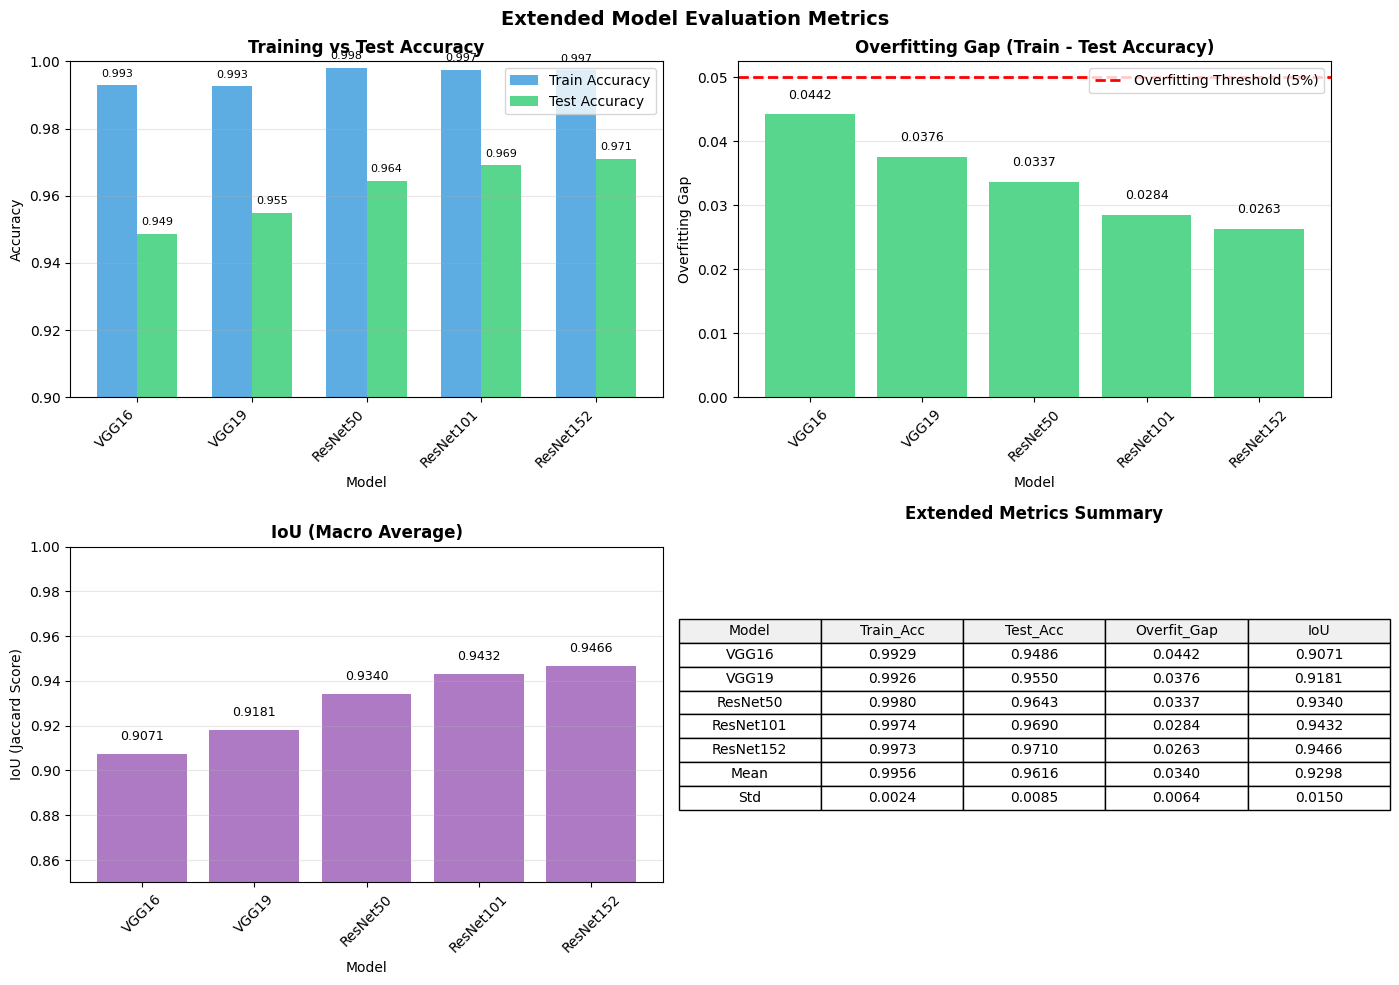


📁 Saved to: /mnt/f/course/computer_vision/models//extended_metrics_visualization.png


In [7]:
"""
視覺化 Extended Metrics: Training vs Test Accuracy, IoU, Overfitting Gap
"""
if len(extended_results) == 0:
    print("No extended results to visualize!")
else:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    model_names = list(extended_results.keys())
    train_accs = [extended_results[m]['train_accuracy'] for m in model_names]
    test_accs = [extended_results[m]['test_accuracy'] for m in model_names]
    gaps = [extended_results[m]['overfitting_gap'] for m in model_names]
    ious = [extended_results[m]['iou_macro'] for m in model_names]
    
    # 1. Training vs Test Accuracy 比較
    ax1 = axes[0, 0]
    x = np.arange(len(model_names))
    width = 0.35
    bars1 = ax1.bar(x - width/2, train_accs, width, label='Train Accuracy', color='#3498db', alpha=0.8)
    bars2 = ax1.bar(x + width/2, test_accs, width, label='Test Accuracy', color='#2ecc71', alpha=0.8)
    ax1.set_xlabel('Model')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Training vs Test Accuracy', fontsize=12, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_names, rotation=45, ha='right')
    ax1.set_ylim(0.9, 1.0)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    for bar in bars1:
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, f'{bar.get_height():.3f}', 
                 ha='center', va='bottom', fontsize=8)
    for bar in bars2:
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, f'{bar.get_height():.3f}', 
                 ha='center', va='bottom', fontsize=8)
    
    # 2. Overfitting Gap
    ax2 = axes[0, 1]
    colors = ['#e74c3c' if g > 0.05 else '#2ecc71' for g in gaps]
    bars = ax2.bar(model_names, gaps, color=colors, alpha=0.8)
    ax2.axhline(y=0.05, color='red', linestyle='--', linewidth=2, label='Overfitting Threshold (5%)')
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax2.set_xlabel('Model')
    ax2.set_ylabel('Overfitting Gap')
    ax2.set_title('Overfitting Gap (Train - Test Accuracy)', fontsize=12, fontweight='bold')
    ax2.tick_params(axis='x', rotation=45)
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    for bar in bars:
        yval = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, yval + 0.002, f'{yval:.4f}', 
                 ha='center', va='bottom', fontsize=9)
    
    # 3. IoU (Jaccard Score)
    ax3 = axes[1, 0]
    bars = ax3.bar(model_names, ious, color='#9b59b6', alpha=0.8)
    ax3.set_xlabel('Model')
    ax3.set_ylabel('IoU (Jaccard Score)')
    ax3.set_title('IoU (Macro Average)', fontsize=12, fontweight='bold')
    ax3.tick_params(axis='x', rotation=45)
    ax3.set_ylim(0.85, 1.0)
    ax3.grid(axis='y', alpha=0.3)
    for bar in bars:
        yval = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f'{yval:.4f}', 
                 ha='center', va='bottom', fontsize=9)
    
    # 4. 綜合雷達圖
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # 建立表格
    table_data = []
    for model_name in model_names:
        data = extended_results[model_name]
        table_data.append([
            model_name,
            f"{data['train_accuracy']:.4f}",
            f"{data['test_accuracy']:.4f}",
            f"{data['overfitting_gap']:.4f}",
            f"{data['iou_macro']:.4f}"
        ])
    
    # 加入統計行
    table_data.append([
        'Mean',
        f"{np.mean(train_accs):.4f}",
        f"{np.mean(test_accs):.4f}",
        f"{np.mean(gaps):.4f}",
        f"{np.mean(ious):.4f}"
    ])
    table_data.append([
        'Std',
        f"{np.std(train_accs):.4f}",
        f"{np.std(test_accs):.4f}",
        f"{np.std(gaps):.4f}",
        f"{np.std(ious):.4f}"
    ])
    
    table = ax4.table(
        cellText=table_data,
        colLabels=['Model', 'Train_Acc', 'Test_Acc', 'Overfit_Gap', 'IoU'],
        loc='center',
        cellLoc='center',
        colColours=['#f0f0f0']*5
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    ax4.set_title('Extended Metrics Summary', fontsize=12, fontweight='bold', pad=20)
    
    plt.suptitle('Extended Model Evaluation Metrics', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{MODEL_DIR}/extended_metrics_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n📁 Saved to: {MODEL_DIR}/extended_metrics_visualization.png")

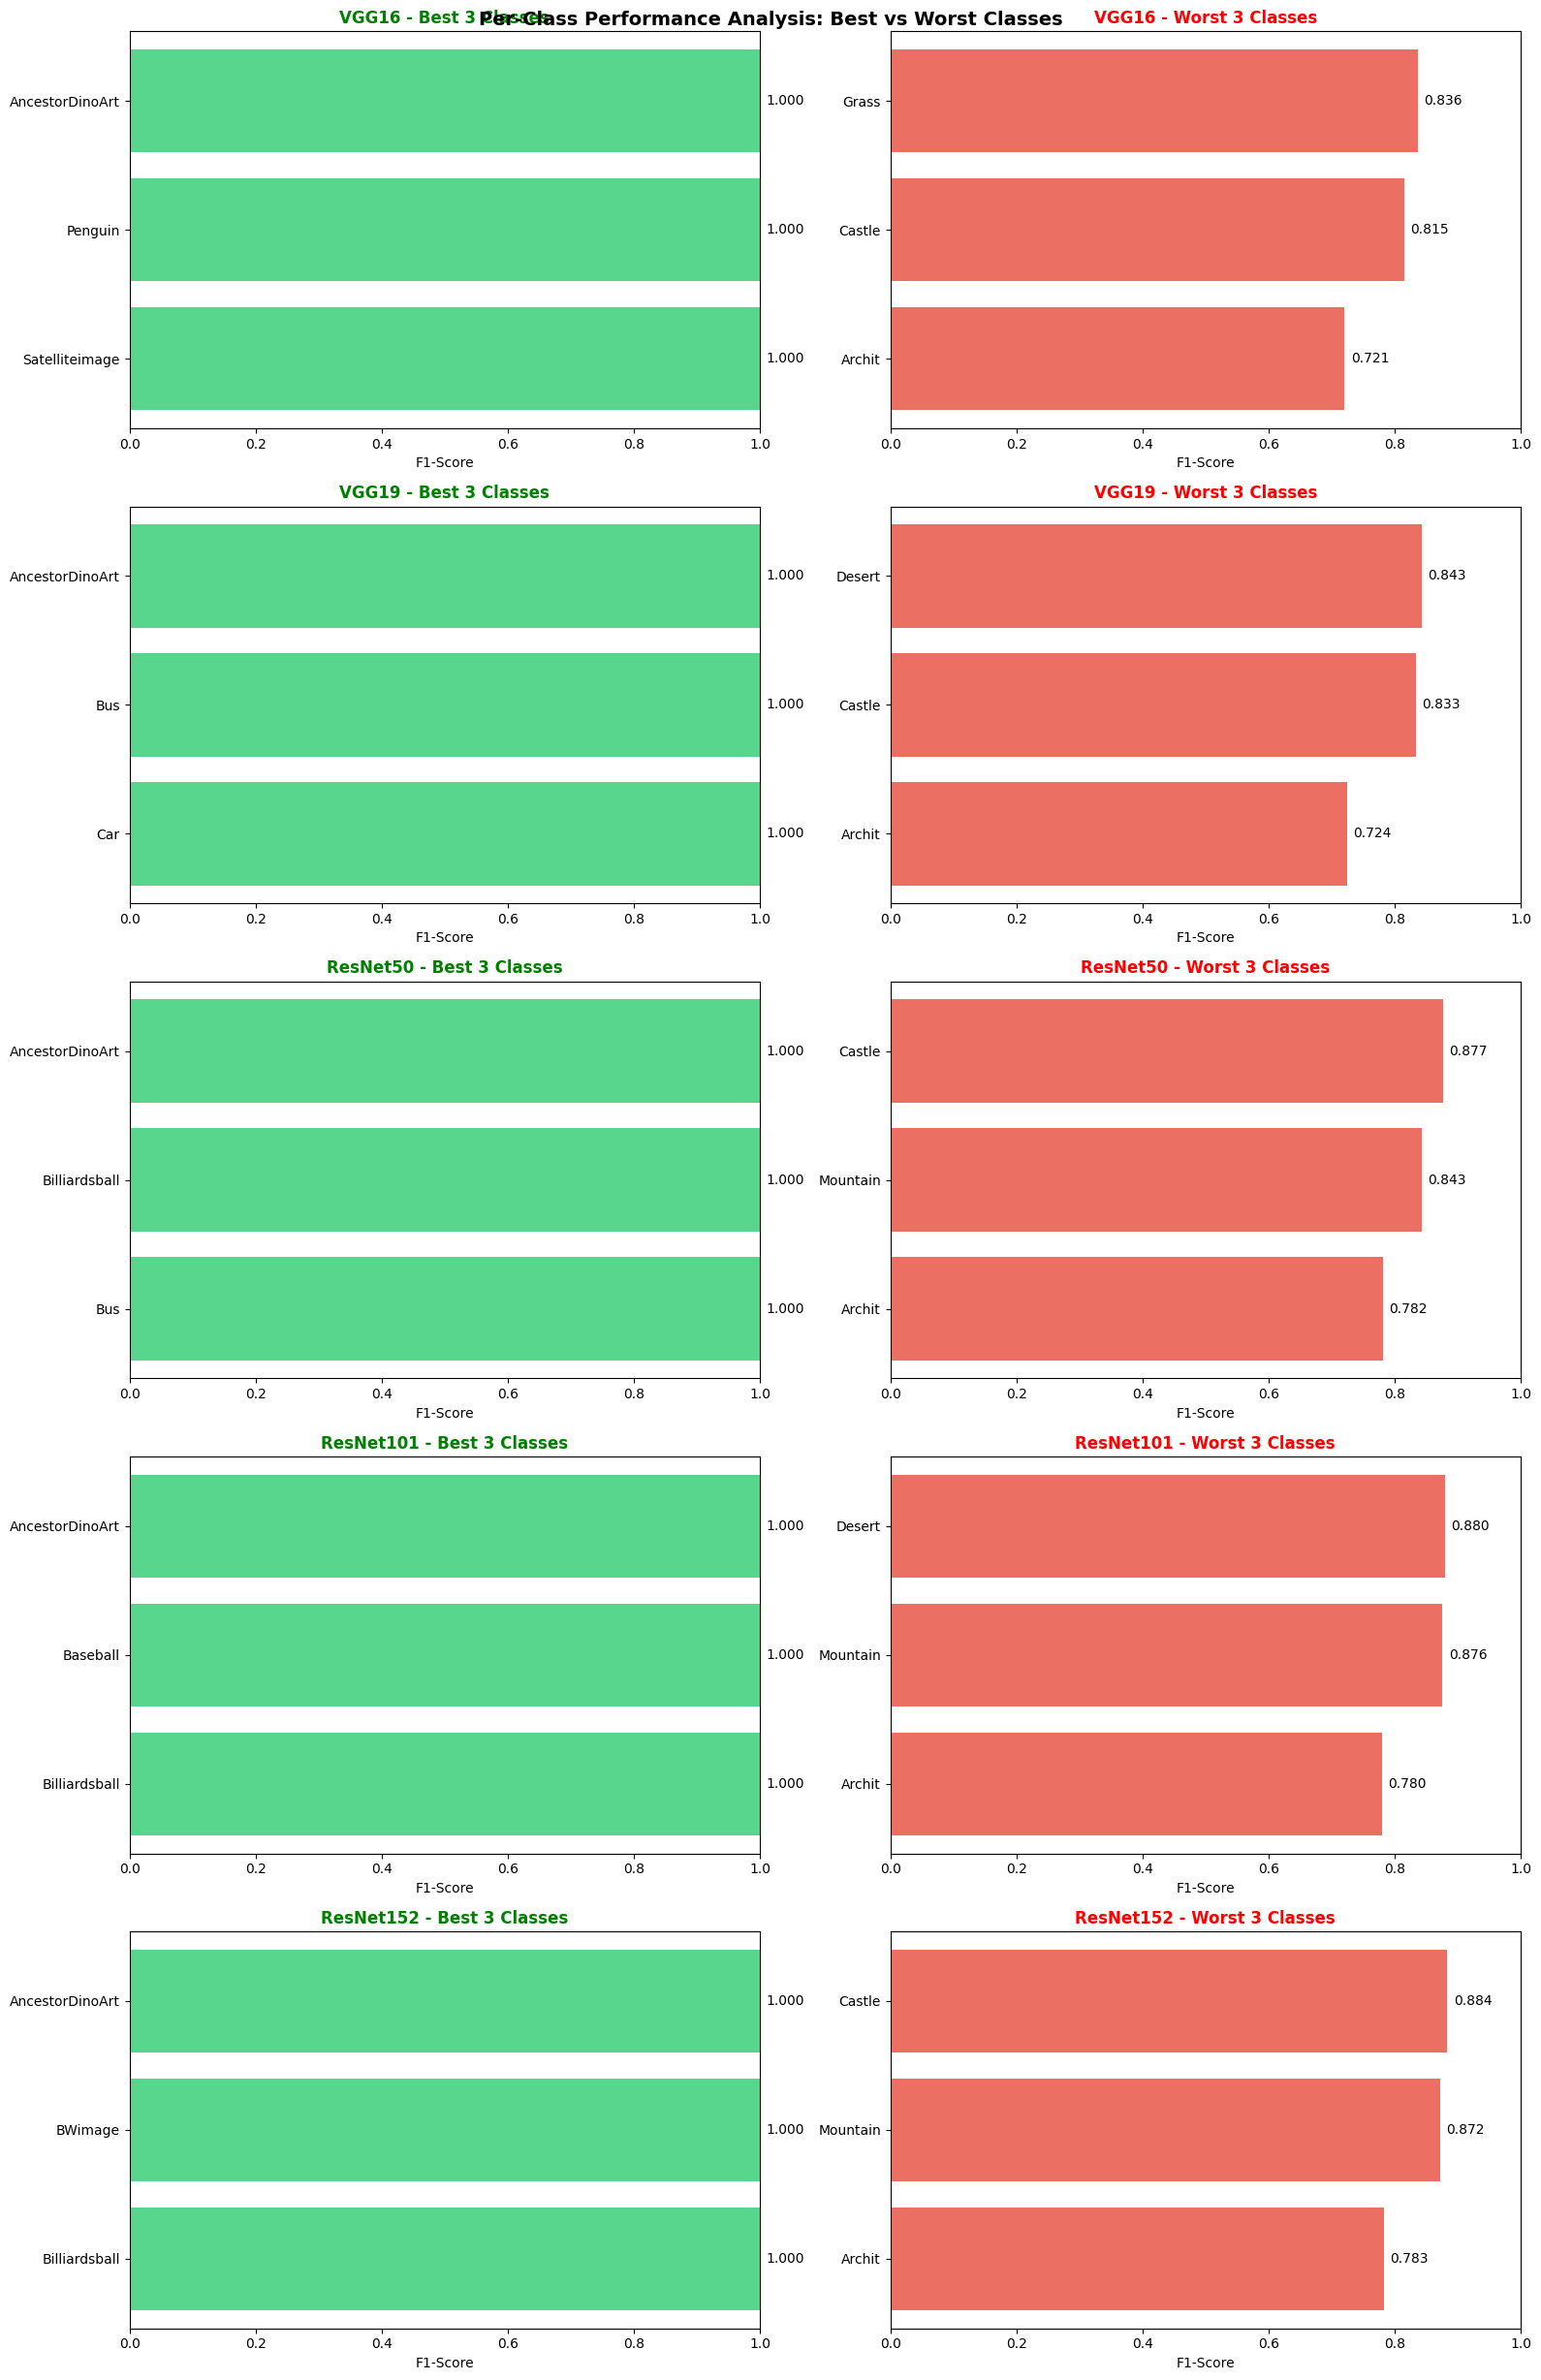

📁 Saved to: /mnt/f/course/computer_vision/models//best_worst_classes.png


In [8]:
"""
視覺化 Best 3 和 Worst 3 類別
"""
if len(per_class_results) == 0:
    print("No models to visualize!")
else:
    # 為每個模型繪製 Best/Worst 類別比較
    fig, axes = plt.subplots(len(per_class_results), 2, figsize=(16, 5 * len(per_class_results)))

    if len(per_class_results) == 1:
        axes = axes.reshape(1, -1)

    for idx, (model_name, data) in enumerate(per_class_results.items()):
        best_3 = data['best_3']
        worst_3 = data['worst_3']
        
        # Best 3 圖
        ax_best = axes[idx, 0]
        classes_best = [x[0] for x in best_3]
        f1_best = [x[1] for x in best_3]
        bars_best = ax_best.barh(classes_best, f1_best, color='#2ecc71', alpha=0.8)
        ax_best.set_xlim(0, 1.0)
        ax_best.set_xlabel('F1-Score')
        ax_best.set_title(f'{model_name} - Best 3 Classes', fontsize=12, fontweight='bold', color='green')
        ax_best.invert_yaxis()
        for bar, val in zip(bars_best, f1_best):
            ax_best.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
                         va='center', fontsize=10)
        
        # Worst 3 圖
        ax_worst = axes[idx, 1]
        classes_worst = [x[0] for x in worst_3]
        f1_worst = [x[1] for x in worst_3]
        bars_worst = ax_worst.barh(classes_worst, f1_worst, color='#e74c3c', alpha=0.8)
        ax_worst.set_xlim(0, 1.0)
        ax_worst.set_xlabel('F1-Score')
        ax_worst.set_title(f'{model_name} - Worst 3 Classes', fontsize=12, fontweight='bold', color='red')
        ax_worst.invert_yaxis()
        for bar, val in zip(bars_worst, f1_worst):
            ax_worst.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
                         va='center', fontsize=10)

    plt.suptitle('Per-Class Performance Analysis: Best vs Worst Classes', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{MODEL_DIR}/best_worst_classes.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"📁 Saved to: {MODEL_DIR}/best_worst_classes.png")


In [7]:
"""
跨模型分析：找出所有模型中一致表現好/差的類別
"""
if len(per_class_results) == 0:
    print("No results to analyze!")
else:
    # 統計每個類別在所有模型中的平均 F1 分數
    all_class_f1 = {class_name: [] for class_name in class_names}

    for model_name, data in per_class_results.items():
        for class_name, metrics in data['class_metrics'].items():
            all_class_f1[class_name].append(metrics['f1-score'])

    # 計算平均和標準差
    class_avg_f1 = {}
    for class_name, f1_list in all_class_f1.items():
        if len(f1_list) > 0:
            class_avg_f1[class_name] = {
                'mean': np.mean(f1_list),
                'std': np.std(f1_list),
                'min': np.min(f1_list),
                'max': np.max(f1_list),
            }

    # 排序
    sorted_by_mean = sorted(class_avg_f1.items(), key=lambda x: x[1]['mean'], reverse=True)

    print("="*80)
    print("📊 Cross-Model Analysis: Average F1-Score per Class (across all models)")
    print("="*80)

    print("\n✅ TOP 3 Classes (Consistently Best across all models):")
    for rank, (cls, stats) in enumerate(sorted_by_mean[:3], 1):
        print(f"   {rank}. {cls}: Mean F1={stats['mean']:.4f} (±{stats['std']:.4f}), Range=[{stats['min']:.4f}, {stats['max']:.4f}]")

    print("\n❌ BOTTOM 3 Classes (Consistently Worst across all models):")
    for rank, (cls, stats) in enumerate(sorted_by_mean[-3:], 1):
        print(f"   {rank}. {cls}: Mean F1={stats['mean']:.4f} (±{stats['std']:.4f}), Range=[{stats['min']:.4f}, {stats['max']:.4f}]")

    # 建立 DataFrame 並儲存
    df_class_analysis = pd.DataFrame([
        {
            'Class': cls,
            'Mean_F1': stats['mean'],
            'Std_F1': stats['std'],
            'Min_F1': stats['min'],
            'Max_F1': stats['max'],
        }
        for cls, stats in sorted_by_mean
    ])

    print("\n\n📋 Complete Class Performance Ranking:")
    print(df_class_analysis.to_string(index=False))

    # 儲存結果
    df_class_analysis.to_csv(f'{MODEL_DIR}/class_performance_analysis.csv', index=False)
    print(f"\n📁 Saved to: {MODEL_DIR}/class_performance_analysis.csv")


📊 Cross-Model Analysis: Average F1-Score per Class (across all models)

✅ TOP 3 Classes (Consistently Best across all models):
   1. AncestorDinoArt: Mean F1=1.0000 (±0.0000), Range=[1.0000, 1.0000]
   2. Satelliteimage: Mean F1=1.0000 (±0.0000), Range=[1.0000, 1.0000]
   3. Penguin: Mean F1=0.9983 (±0.0033), Range=[0.9917, 1.0000]

❌ BOTTOM 3 Classes (Consistently Worst across all models):
   1. Mountain: Mean F1=0.8696 (±0.0192), Range=[0.8430, 0.9000]
   2. Castle: Mean F1=0.8599 (±0.0301), Range=[0.8148, 0.8906]
   3. Archit: Mean F1=0.7578 (±0.0289), Range=[0.7207, 0.7826]


📋 Complete Class Performance Ranking:
            Class  Mean_F1   Std_F1   Min_F1   Max_F1
  AncestorDinoArt 1.000000 0.000000 1.000000 1.000000
   Satelliteimage 1.000000 0.000000 1.000000 1.000000
          Penguin 0.998347 0.003306 0.991736 1.000000
             Ship 0.998347 0.003306 0.991736 1.000000
             Owls 0.998319 0.003361 0.991597 1.000000
              Bus 0.996666 0.004083 0.991597 1.0000

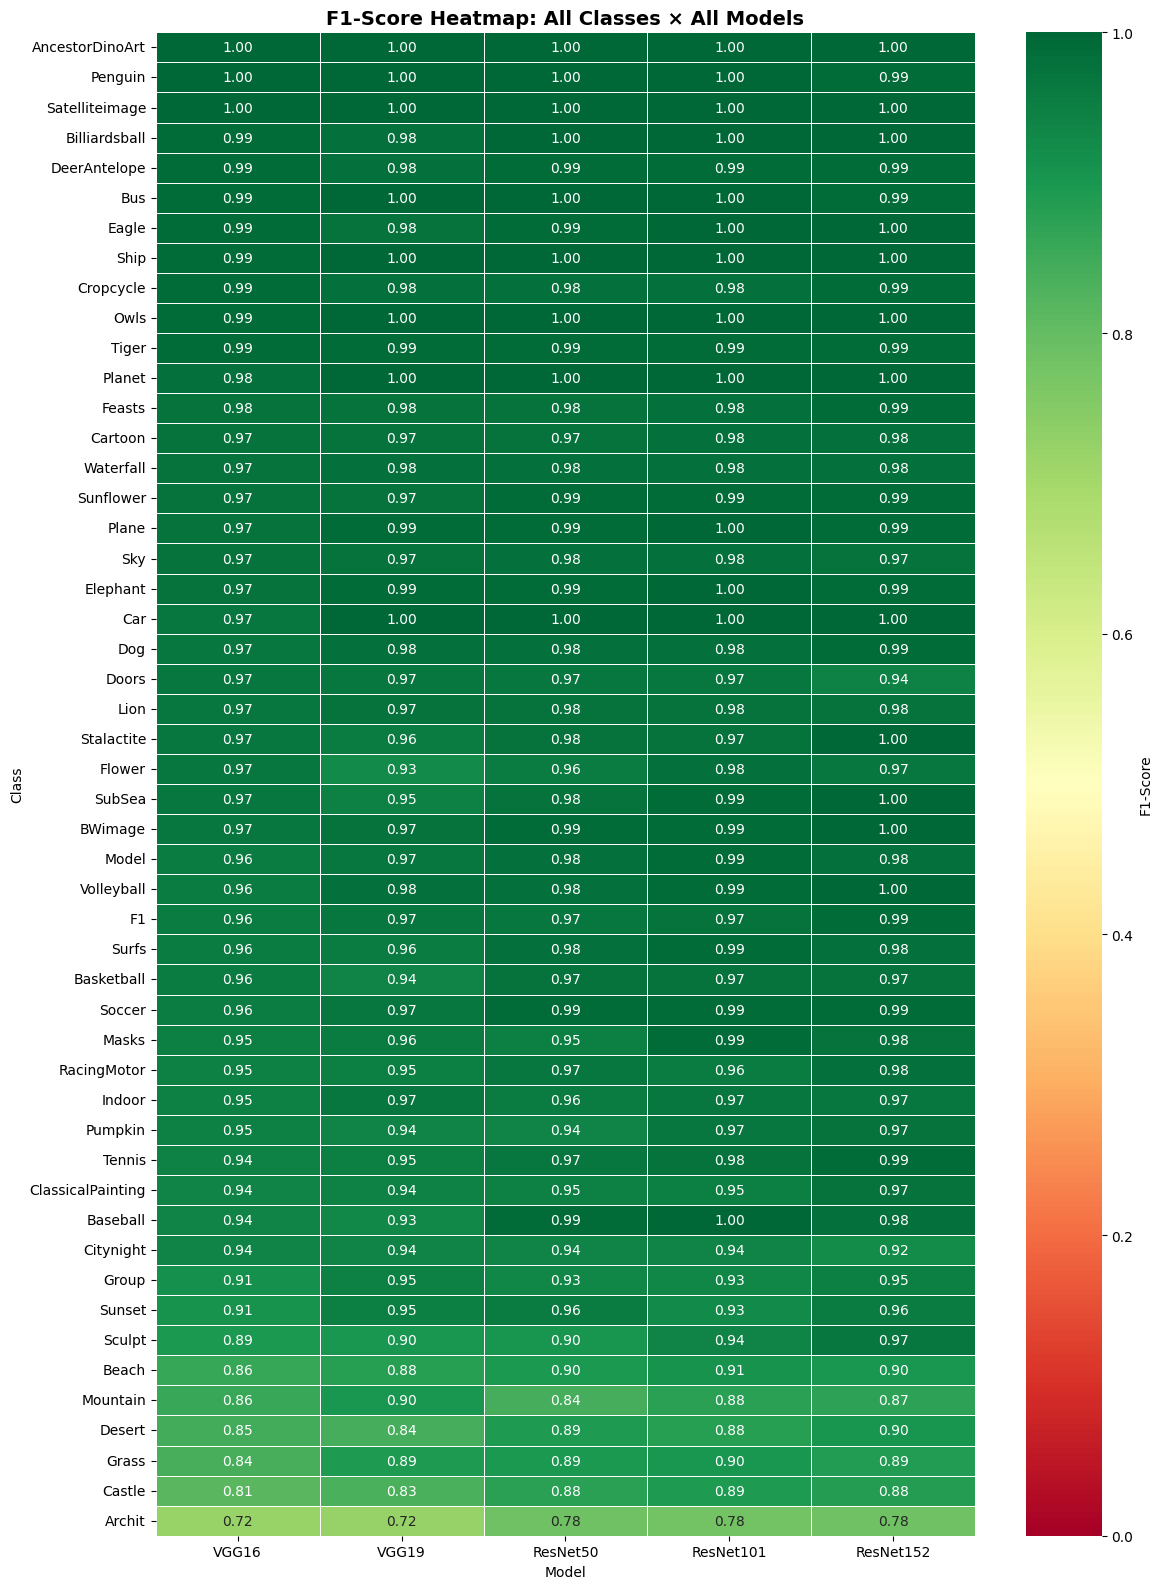


📁 Heatmap saved to: /mnt/f/course/computer_vision/models//f1_heatmap.png


In [8]:
"""
熱力圖：所有類別在各模型的 F1-Score
"""
if len(per_class_results) == 0:
    print("No results to visualize!")
else:
    # 建立熱力圖數據
    heatmap_data = []
    for class_name in class_names:
        row = []
        for model_name in per_class_results.keys():
            f1 = per_class_results[model_name]['class_metrics'].get(class_name, {}).get('f1-score', 0)
            row.append(f1)
        heatmap_data.append(row)

    df_heatmap = pd.DataFrame(
        heatmap_data,
        index=class_names,
        columns=list(per_class_results.keys())
    )

    # 繪製熱力圖
    plt.figure(figsize=(12, 16))
    sns.heatmap(
        df_heatmap.sort_values(by=list(per_class_results.keys())[0], ascending=False),
        annot=True,
        fmt='.2f',
        cmap='RdYlGn',
        vmin=0,
        vmax=1,
        linewidths=0.5,
        cbar_kws={'label': 'F1-Score'}
    )
    plt.title('F1-Score Heatmap: All Classes × All Models', fontsize=14, fontweight='bold')
    plt.xlabel('Model')
    plt.ylabel('Class')
    plt.tight_layout()
    plt.savefig(f'{MODEL_DIR}/f1_heatmap.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\n📁 Heatmap saved to: {MODEL_DIR}/f1_heatmap.png")


Best Model: ResNet152 (Accuracy: 0.9710)


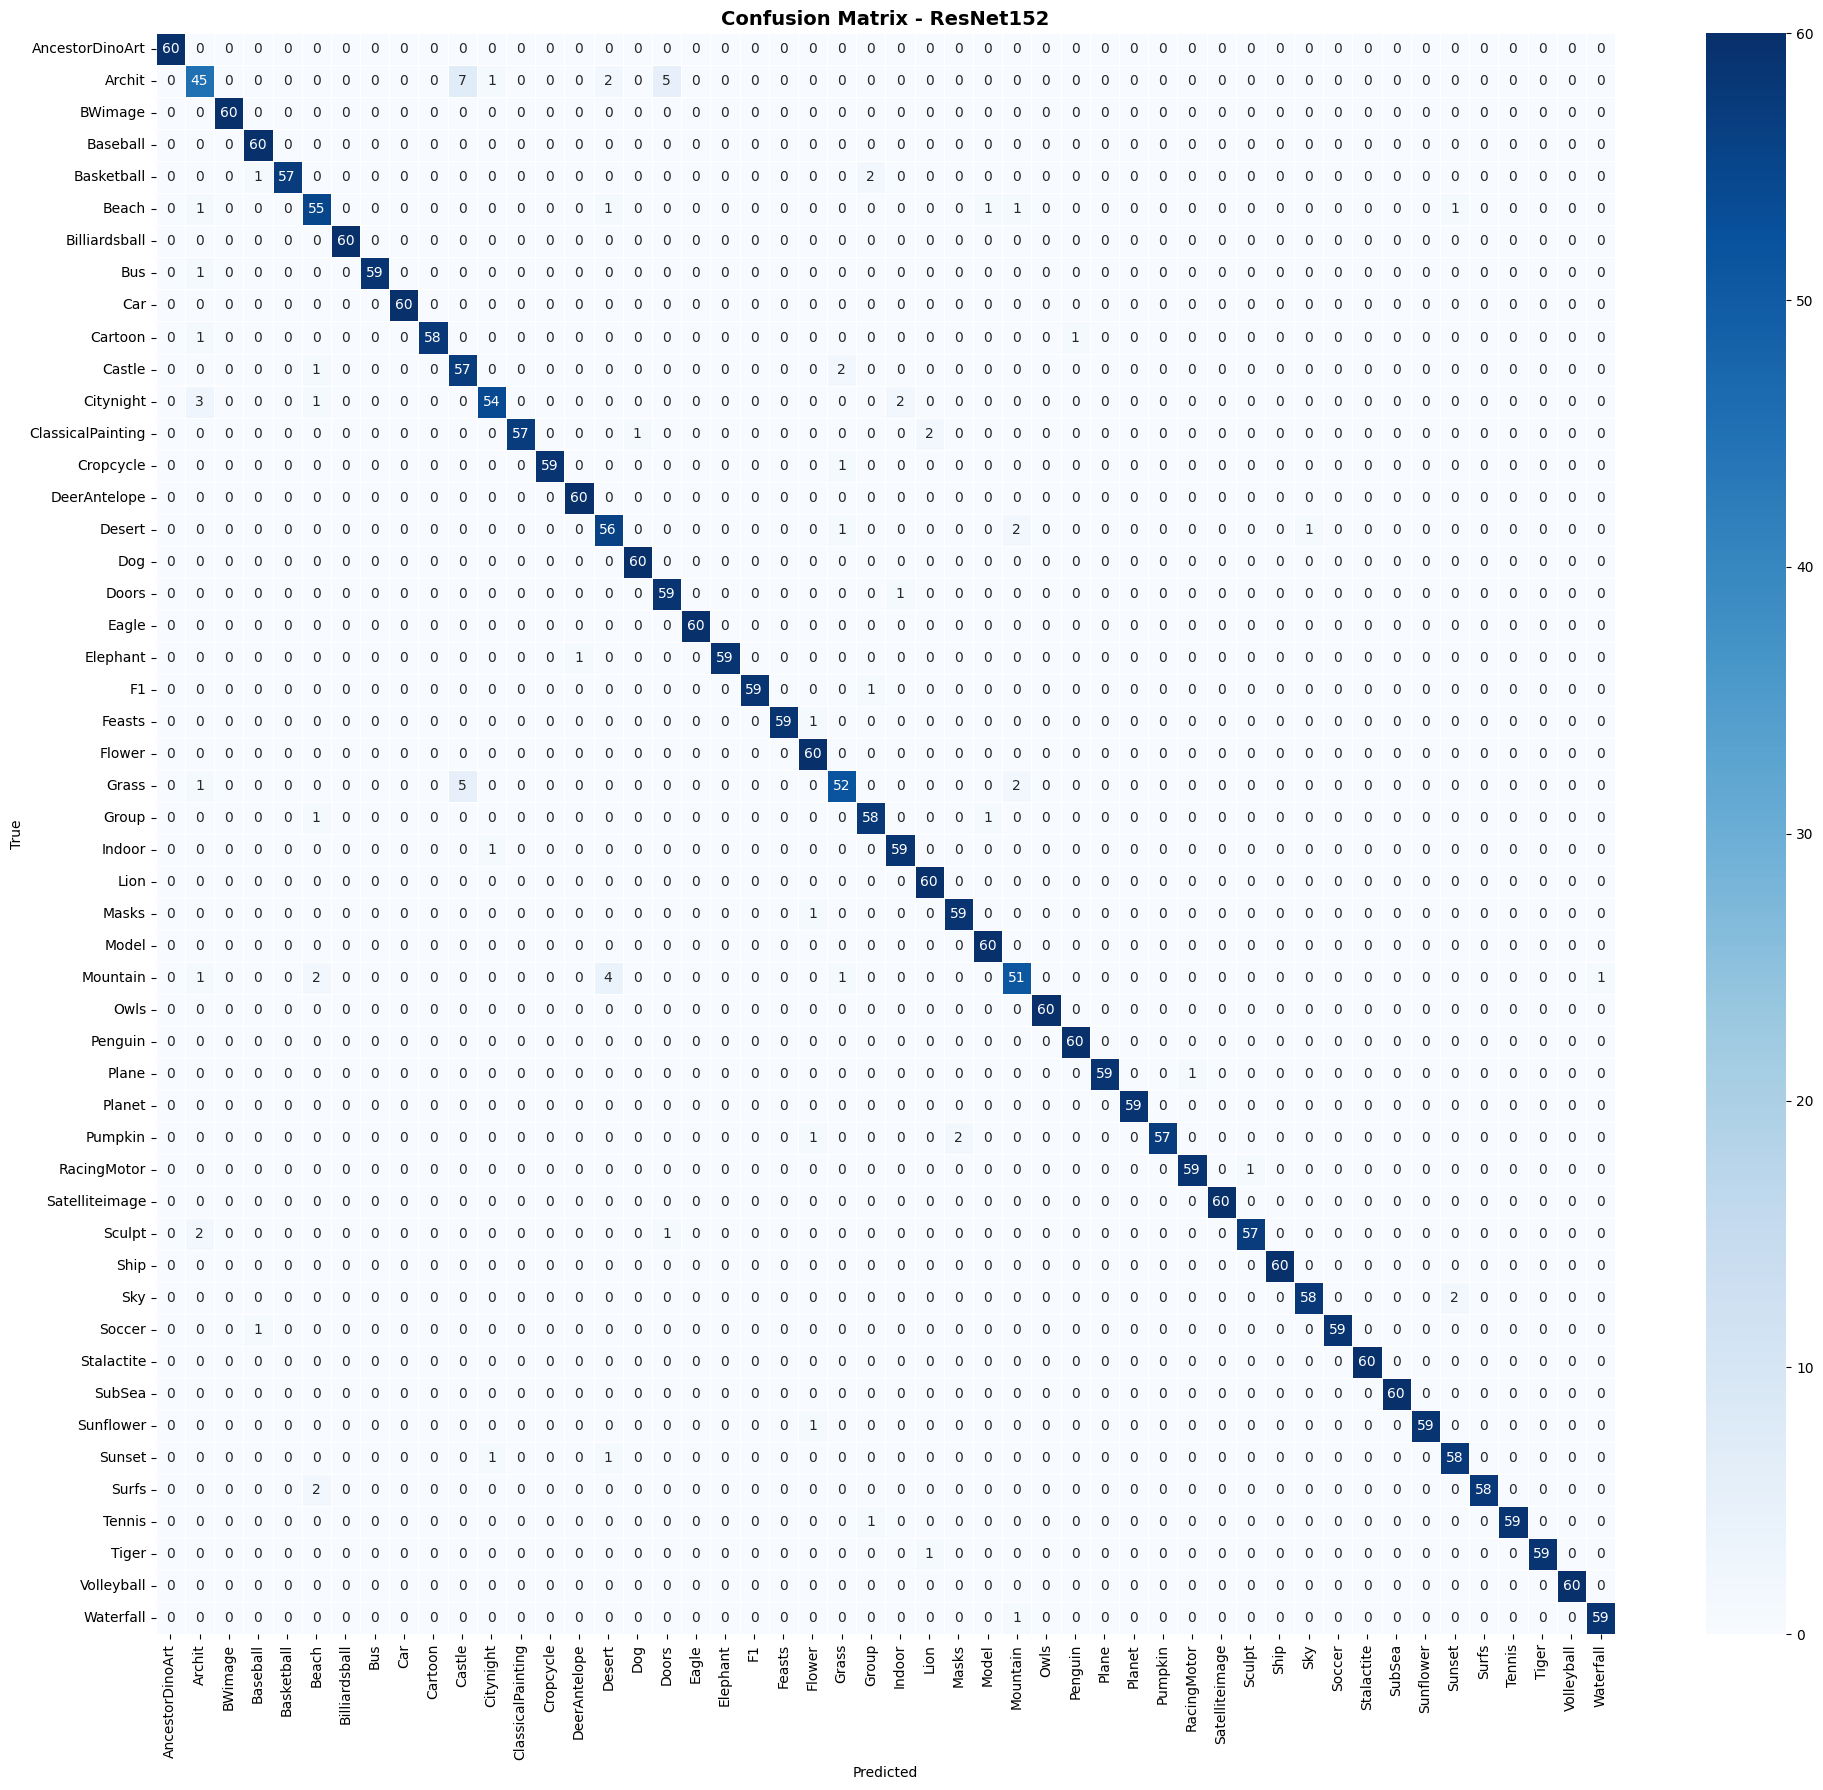


📁 Confusion matrix saved to: /mnt/f/course/computer_vision/models//confusion_matrix_ResNet152.png


In [9]:
"""
繪製最佳模型的混淆矩陣
"""
if len(per_class_results) == 0:
    print("No results to visualize!")
else:
    # 找出最佳模型
    best_model = max(per_class_results.items(), key=lambda x: x[1]['overall_accuracy'])
    best_model_name = best_model[0]
    best_y_pred = best_model[1]['y_pred']
    
    print(f"Best Model: {best_model_name} (Accuracy: {best_model[1]['overall_accuracy']:.4f})")
    
    # 計算混淆矩陣
    cm = confusion_matrix(y_true, best_y_pred)
    
    # 繪製混淆矩陣
    plt.figure(figsize=(20, 18))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        linewidths=0.5
    )
    plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'{MODEL_DIR}/confusion_matrix_{best_model_name}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n📁 Confusion matrix saved to: {MODEL_DIR}/confusion_matrix_{best_model_name}.png")
